
# Q learning (Q-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    #     print('state, action, reward, done, info')
    #     print(state, action, reward, done, info)
    if done:
    #         print('state, action, reward, done, info')
    #         print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [14]:
# Data of the model
def model_input(state_size):
    # Current and next states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Previous and current actions given
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    
    # End of episodes/goal/task where nextQs = 0 and Qs=rs
    dones = tf.placeholder(tf.bool, [None], name='dones') # masked

    # Qs = qs+ (gamma * nextQs)
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs') # masked
    nextQs_D = tf.placeholder(tf.float32, [None], name='nextQs_D') # masked
    
    # returning the given data to the model
    return prev_actions, states, actions, next_states, dones, nextQs, nextQs_D

In [15]:
# Generator: Generating/predicting action and next states
def generator(prev_actions, states, action_size, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(action_size + state_size))
        actions_logits, next_states_logits = tf.split(axis=1, num_or_size_splits=[action_size, state_size], 
                                                      value=logits)
        #predictions = tf.nn.softmax(actions_logits)
        #predictions = tf.sigmoid(next_states_logits)

        # return actions and states logits
        return actions_logits, next_states_logits

In [16]:
def discriminator(prev_actions, states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        #print(x_fused.shape)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        #print(h1.shape)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        #print(h2.shape)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)
        #predictions = tf.nn.softmax(logits)

        # return reward logits/Qs
        return logits

In [17]:
# The model loss for predicted/generated actions
def model_loss(prev_actions, states, actions, # model input data for Qs/qs/rs 
               nextQs, gamma, # model input data for targetQs
               state_size, action_size, hidden_size): # model init for Qs
    # Calculating Qs total rewards
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, _ = generator(prev_actions=prev_actions_onehot, states=states, 
                                  hidden_size=hidden_size, state_size=state_size, action_size=action_size)
    
    # Masking actions_logits unmasked
    actions_mask = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_masked = tf.multiply(actions_logits, actions_mask)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # Bellman equaion for calculating total rewards using current reward + total future rewards/nextQs
    qs = tf.sigmoid(Qs) # qt
    targetQs = qs + (gamma * nextQs)
    
    # Calculating the loss: logits/predictions vs labels
    q_loss = tf.reduce_mean(tf.square(Qs - targetQs))

    return actions_logits, q_loss

In [18]:
# Outputing the unmasked nextQs for D to be used as the target/label
def model_output(actions, next_states,
                 action_size, hidden_size):
    # Discriminator for nextQs_D
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    nextQs_D_unmasked = discriminator(prev_actions=actions_onehot, states=next_states, hidden_size=hidden_size)
    
    # Returning unmasked nextQs_D to masked using dones/ends of episodes
    return nextQs_D_unmasked

In [19]:
# The model loss for the NEW idea G & D
def model_loss2(nextQs_D, gamma, 
                prev_actions, states, 
                action_size, hidden_size):
    # Calculating Qs total rewards using Discriminator
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    Qs = discriminator(prev_actions=prev_actions_onehot, states=states, hidden_size=hidden_size, reuse=True)
        
    # Bellman equaion: Qs = rt/qt + nextQs_G/D
    qs = tf.sigmoid(Qs) # qt
    targetQs_D = qs + (gamma * nextQs_D)
    
    # Calculating the loss: logits/predictions vs labels
    d_loss = tf.reduce_mean(tf.square(Qs - targetQs_D))
    return d_loss

In [20]:
# Calculating the loss of generator based on the generated/predicted states and actions
def model_loss3(nextQs_D, gamma,
                prev_actions, states, dones, 
                state_size, action_size, hidden_size):
    # Generator for nextQs_G
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, next_states_logits = generator(prev_actions=prev_actions_onehot, states=states,
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size, reuse=True)
    
    # Discriminator for nextQs_G
    nextQs_G_unmasked = discriminator(prev_actions=actions_logits, states=next_states_logits, 
                                      hidden_size=hidden_size, reuse=True)
    
    # Masking the unmasked nextQs_G using dones/end of episodes/goal
    dones_mask = tf.reshape(tensor=(1 - tf.cast(dtype=nextQs_G_unmasked.dtype, x=dones)), shape=[-1, 1])
    nextQs_G_masked = tf.multiply(nextQs_G_unmasked, dones_mask)
    nextQs_G = tf.reduce_max(axis=1, input_tensor=nextQs_G_masked)

    # Below is the idea behind this loss
    # # Bellman equaion: Qs = rt/qt + nextQs_G/D
    # qs = tf.sigmoid(Qs) # qt
    # targetQs_G = qs + (gamma * nextQs_G)
    # targetQs_D = qs + (gamma * nextQs_D)
    # targetQs_G = targetQs_D
    # nextQs_G = nextQs_D 
    # Calculating the loss: logits/predictions vs labels
    g_loss = tf.reduce_mean(tf.square(nextQs_G - nextQs_D))
    
    # Returning g_loss which should impact Generator
    return g_loss

In [21]:
def model_opt(q_loss, g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Generator loss for action prediction
    :param g_loss: Generator loss for state prediction
    :param d_loss: Discriminator loss for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Used for BN (batchnorm params)
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=g_vars) # action prediction
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars) # state prediction
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars) # reward prediction

    return q_opt, g_opt, d_opt

In [22]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate, gamma):

        ####################################### Model data inputs/outputs #######################################
        # Input of the Model: make the data available inside the framework
        self.prev_actions, self.states, self.actions, self.next_states, self.dones, self.nextQs, self.nextQs_D = model_input(
            state_size=state_size)

        # Output of the Model
        self.nextQs_D_unmasked = model_output(actions=self.actions, next_states=self.next_states,
                                              action_size=action_size, hidden_size=hidden_size)
        
        ######################################## Model losses #####################################################
        # Loss of the Model: action prediction/generation
        self.actions_logits, self.q_loss = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init parameters
            prev_actions=self.prev_actions, states=self.states, actions=self.actions, nextQs=self.nextQs) # model input data

        # Loss of the model: reward prob/logits prediction
        self.d_loss = model_loss2(nextQs_D=self.nextQs_D, gamma=gamma,
                                  action_size=action_size, hidden_size=hidden_size,
                                  prev_actions=self.prev_actions, states=self.states)
        
        # Loss of the model: states prediction/generation
        self.g_loss = model_loss3(nextQs_D=self.nextQs_D, gamma=gamma, dones=self.dones,
                                  state_size=state_size, action_size=action_size, hidden_size=hidden_size,
                                  prev_actions=self.prev_actions, states=self.states)
        
        ######################################## Model updates #####################################################
        # Update the model: backward pass and backprop
        self.q_opt, self.g_opt, self.d_opt = model_opt(q_loss=self.q_loss, 
                                                       g_loss=self.g_loss, 
                                                       d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [23]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [24]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [25]:
train_episodes = 2000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [26]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate, 
             gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [27]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, reward, done, info = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()# At
    next_state, reward, done, info = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        
        # Print out reward and done and check if they are the same: They are NOT.
        #print('if done is true:', reward, done)
        
        # # the episode ends so no next state
        # next_state = np.zeros(state.shape)
                
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, reward, done, info = env.step(prev_action)
    else:
        # Print out reward and done and check if they are the same!
        #print('else done is false:', reward, done)
        
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [28]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
q_loss_list = []
g_loss_list = []
d_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        q_loss = 0
        g_loss = 0
        d_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.prev_actions: np.array([prev_action]), 
                             model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, reward, done, info = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                q_loss_list.append((ep, q_loss))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, info = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            #print(prev_actions.shape, states.shape, actions.shape, next_states.shape, dones.shape, dones.dtype)
            #print(dones[:3])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.prev_actions: actions, 
                       model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)
            
            # Masking for the end of episodes/ goals
            next_actions_mask = (1 - dones.astype(next_actions_logits.dtype)).reshape(-1, 1) 
            nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
            nextQs = np.max(nextQs_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            # Calculating nextQs for Discriminator using D(At, St+1)= Qt+1/nextQs_D/nextQs
            # Calculating nextQs for Discriminator using D(~At, ~St+1)= ~Qt+1/nextQs_G/nextQs2
            feed_dict={model.prev_actions: prev_actions, model.states: states,
                       model.actions: actions, model.next_states: next_states}
            nextQs_D_unmasked = sess.run(model.nextQs_D_unmasked, feed_dict)
            
            # Masking for the end of episodes/ goals
            dones_mask = (1 - dones.astype(nextQs_D_unmasked[0].dtype)).reshape(-1, 1)
            nextQs_D_masked = np.multiply(nextQs_D_unmasked[0], dones_mask)
            nextQs_D = np.max(nextQs_D_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            # D(At-1, St)= Qs and qs = tf.sigmoid(Qs)
            # NextQs/Qt+1 are given both:
            # targetQs = qs + gamma * nextQs_G
            # targetQs = qs + gamma * nextQs_D
            feed_dict = {model.prev_actions: prev_actions, 
                         model.states: states, 
                         model.actions: actions, 
                         model.next_states: next_states, 
                         model.dones: dones,
                         model.nextQs: nextQs,
                         model.nextQs_D: nextQs_D}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            ################################################################################
            ################################################################################
                        
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 29.0 Training q_loss: 1.0539 Training g_loss: 0.1093 Training d_loss: 2.2783 Explore P: 0.9971
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 16.0 Training q_loss: 1.0575 Training g_loss: 2.2514 Training d_loss: 2.0394 Explore P: 0.9956
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 30.0 Training q_loss: 0.9180 Training g_loss: 1.9364 Training d_loss: 7.7009 Explore P: 0.9926
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 17.0 Training q_loss: 0.6196 Training g_loss: 2.5091 Tr

-------------------------------------------------------------------------------
Episode: 31 Total reward: 9.0 Training q_loss: 0.4755 Training g_loss: 0.5205 Training d_loss: 14.8217 Explore P: 0.9394
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 32 Total reward: 10.0 Training q_loss: 0.4806 Training g_loss: 0.5570 Training d_loss: 11.8150 Explore P: 0.9384
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 33 Total reward: 13.0 Training q_loss: 0.4552 Training g_loss: 0.7371 Training d_loss: 13.1458 Explore P: 0.9372
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 34 Total reward: 25.0 Training q_loss: 0.4535 Training g_loss: 0.6

-------------------------------------------------------------------------------
Episode: 61 Total reward: 33.0 Training q_loss: 0.4008 Training g_loss: 0.2528 Training d_loss: 21.8657 Explore P: 0.8734
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 62 Total reward: 18.0 Training q_loss: 0.4108 Training g_loss: 0.4711 Training d_loss: 13.1867 Explore P: 0.8719
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 63 Total reward: 18.0 Training q_loss: 0.4044 Training g_loss: 0.2121 Training d_loss: 14.8747 Explore P: 0.8703
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 64 Total reward: 44.0 Training q_loss: 0.4198 Training g_loss: 0.

-------------------------------------------------------------------------------
Episode: 91 Total reward: 15.0 Training q_loss: 0.4495 Training g_loss: 0.4520 Training d_loss: 14.3273 Explore P: 0.8118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 92 Total reward: 27.0 Training q_loss: 0.4540 Training g_loss: 0.6254 Training d_loss: 17.8115 Explore P: 0.8096
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 93 Total reward: 11.0 Training q_loss: 0.4525 Training g_loss: 0.5430 Training d_loss: 19.0808 Explore P: 0.8087
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 94 Total reward: 20.0 Training q_loss: 0.4385 Training g_loss: 0.

-------------------------------------------------------------------------------
Episode: 120 Total reward: 34.0 Training q_loss: 0.4708 Training g_loss: 0.7392 Training d_loss: 8.4294 Explore P: 0.7601
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 121 Total reward: 17.0 Training q_loss: 0.4764 Training g_loss: 0.4513 Training d_loss: 16.8363 Explore P: 0.7588
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 122 Total reward: 22.0 Training q_loss: 0.4734 Training g_loss: 0.1382 Training d_loss: 8.5174 Explore P: 0.7572
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 123 Total reward: 21.0 Training q_loss: 0.4570 Training g_loss: 

-------------------------------------------------------------------------------
Episode: 149 Total reward: 22.0 Training q_loss: 0.5105 Training g_loss: 1.4896 Training d_loss: 14.5168 Explore P: 0.7006
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 150 Total reward: 15.0 Training q_loss: 0.5175 Training g_loss: 0.8138 Training d_loss: 8.3223 Explore P: 0.6995
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 151 Total reward: 50.0 Training q_loss: 0.5435 Training g_loss: 0.7889 Training d_loss: 10.9957 Explore P: 0.6961
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 152 Total reward: 22.0 Training q_loss: 0.5046 Training g_loss:

-------------------------------------------------------------------------------
Episode: 178 Total reward: 32.0 Training q_loss: 0.5113 Training g_loss: 0.3257 Training d_loss: 13.5887 Explore P: 0.6537
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 179 Total reward: 22.0 Training q_loss: 0.4931 Training g_loss: 0.4375 Training d_loss: 18.9540 Explore P: 0.6523
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 180 Total reward: 12.0 Training q_loss: 0.4838 Training g_loss: 0.3605 Training d_loss: 17.5717 Explore P: 0.6516
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 181 Total reward: 22.0 Training q_loss: 0.5316 Training g_loss

-------------------------------------------------------------------------------
Episode: 207 Total reward: 27.0 Training q_loss: 0.5730 Training g_loss: 1.2414 Training d_loss: 12.8067 Explore P: 0.6135
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 208 Total reward: 13.0 Training q_loss: 0.5603 Training g_loss: 0.7599 Training d_loss: 8.1490 Explore P: 0.6128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 209 Total reward: 15.0 Training q_loss: 0.5894 Training g_loss: 0.4005 Training d_loss: 17.5365 Explore P: 0.6118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 210 Total reward: 9.0 Training q_loss: 0.5490 Training g_loss: 

-------------------------------------------------------------------------------
Episode: 236 Total reward: 17.0 Training q_loss: 0.5599 Training g_loss: 0.7030 Training d_loss: 15.0911 Explore P: 0.5749
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 237 Total reward: 22.0 Training q_loss: 0.5545 Training g_loss: 1.0583 Training d_loss: 8.8684 Explore P: 0.5737
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 238 Total reward: 43.0 Training q_loss: 0.5489 Training g_loss: 0.6353 Training d_loss: 17.2794 Explore P: 0.5713
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 239 Total reward: 15.0 Training q_loss: 0.5818 Training g_loss:

-------------------------------------------------------------------------------
Episode: 265 Total reward: 17.0 Training q_loss: 0.5821 Training g_loss: 1.1486 Training d_loss: 18.8121 Explore P: 0.5386
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 266 Total reward: 19.0 Training q_loss: 0.6113 Training g_loss: 0.6746 Training d_loss: 10.1588 Explore P: 0.5376
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 267 Total reward: 20.0 Training q_loss: 0.5810 Training g_loss: 0.9658 Training d_loss: 19.0134 Explore P: 0.5365
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 268 Total reward: 34.0 Training q_loss: 0.5558 Training g_loss

-------------------------------------------------------------------------------
Episode: 294 Total reward: 18.0 Training q_loss: 198.9711 Training g_loss: 3.6582 Training d_loss: 15.0890 Explore P: 0.5023
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 295 Total reward: 16.0 Training q_loss: 164.3305 Training g_loss: 1.7456 Training d_loss: 18.0768 Explore P: 0.5015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 296 Total reward: 16.0 Training q_loss: 156.2057 Training g_loss: 4.9332 Training d_loss: 6.6631 Explore P: 0.5007
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 297 Total reward: 18.0 Training q_loss: 172.4898 Training

-------------------------------------------------------------------------------
Episode: 323 Total reward: 24.0 Training q_loss: 230.7971 Training g_loss: 60.2780 Training d_loss: 12.2234 Explore P: 0.4687
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 324 Total reward: 21.0 Training q_loss: 206.7519 Training g_loss: 15.9545 Training d_loss: 10.1788 Explore P: 0.4678
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 325 Total reward: 21.0 Training q_loss: 247.8504 Training g_loss: 8.8243 Training d_loss: 16.9100 Explore P: 0.4668
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 326 Total reward: 18.0 Training q_loss: 216.9770 Train

-------------------------------------------------------------------------------
Episode: 352 Total reward: 16.0 Training q_loss: 886.5575 Training g_loss: 4.1211 Training d_loss: 12.9212 Explore P: 0.4285
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 353 Total reward: 16.0 Training q_loss: 598.6820 Training g_loss: 9.6137 Training d_loss: 19.4577 Explore P: 0.4278
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 354 Total reward: 39.0 Training q_loss: 575.4377 Training g_loss: 10.9231 Training d_loss: 20.3712 Explore P: 0.4262
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 355 Total reward: 38.0 Training q_loss: 793.9905 Traini

-------------------------------------------------------------------------------
Episode: 381 Total reward: 29.0 Training q_loss: 933.1639 Training g_loss: 4.0273 Training d_loss: 14.6595 Explore P: 0.3973
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 382 Total reward: 21.0 Training q_loss: 1040.5216 Training g_loss: 22.6487 Training d_loss: 10.4616 Explore P: 0.3965
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 383 Total reward: 26.0 Training q_loss: 823.5333 Training g_loss: 4.0015 Training d_loss: 21.4755 Explore P: 0.3955
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 384 Total reward: 36.0 Training q_loss: 959.1224 Train

-------------------------------------------------------------------------------
Episode: 410 Total reward: 52.0 Training q_loss: 939.4334 Training g_loss: 12.1765 Training d_loss: 14.9746 Explore P: 0.3672
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 411 Total reward: 26.0 Training q_loss: 877.1561 Training g_loss: 12.3473 Training d_loss: 31.0805 Explore P: 0.3663
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 412 Total reward: 53.0 Training q_loss: 767.4102 Training g_loss: 6.1024 Training d_loss: 13.8907 Explore P: 0.3644
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 413 Total reward: 48.0 Training q_loss: 879.0619 Train

-------------------------------------------------------------------------------
Episode: 439 Total reward: 26.0 Training q_loss: 964.6619 Training g_loss: 17.3147 Training d_loss: 13.0475 Explore P: 0.3432
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 440 Total reward: 18.0 Training q_loss: 1337.2434 Training g_loss: 6.5864 Training d_loss: 28.2694 Explore P: 0.3426
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 441 Total reward: 26.0 Training q_loss: 1165.2822 Training g_loss: 14.8505 Training d_loss: 10.1036 Explore P: 0.3417
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 442 Total reward: 51.0 Training q_loss: 1508.9319 Tr

-------------------------------------------------------------------------------
Episode: 468 Total reward: 37.0 Training q_loss: 1986.9465 Training g_loss: 7.5213 Training d_loss: 23.2675 Explore P: 0.3193
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 469 Total reward: 38.0 Training q_loss: 1492.9352 Training g_loss: 38.1863 Training d_loss: 18.8753 Explore P: 0.3181
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 470 Total reward: 21.0 Training q_loss: 2124.1765 Training g_loss: 30.1791 Training d_loss: 17.3425 Explore P: 0.3175
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 471 Total reward: 21.0 Training q_loss: 2693.8206 T

-------------------------------------------------------------------------------
Episode: 497 Total reward: 18.0 Training q_loss: 3854.6228 Training g_loss: 99.8045 Training d_loss: 18.0215 Explore P: 0.2978
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 498 Total reward: 27.0 Training q_loss: 3192.6260 Training g_loss: 52.9794 Training d_loss: 20.0312 Explore P: 0.2970
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 499 Total reward: 13.0 Training q_loss: 3748.0667 Training g_loss: 11.9662 Training d_loss: 8.3187 Explore P: 0.2966
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 500 Total reward: 56.0 Training q_loss: 4389.0630 T

-------------------------------------------------------------------------------
Episode: 526 Total reward: 28.0 Training q_loss: 4329.8862 Training g_loss: 536.7781 Training d_loss: 15.0641 Explore P: 0.2645
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 527 Total reward: 40.0 Training q_loss: 3782.7861 Training g_loss: 394.6272 Training d_loss: 9.0720 Explore P: 0.2635
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 528 Total reward: 88.0 Training q_loss: 3691.2341 Training g_loss: 25.5638 Training d_loss: 8.8924 Explore P: 0.2612
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 529 Total reward: 38.0 Training q_loss: 3995.1096 

-------------------------------------------------------------------------------
Episode: 555 Total reward: 24.0 Training q_loss: 6673.1748 Training g_loss: 291.9604 Training d_loss: 8.9888 Explore P: 0.2344
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 556 Total reward: 69.0 Training q_loss: 6478.3462 Training g_loss: 39.3493 Training d_loss: 14.8711 Explore P: 0.2329
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 557 Total reward: 23.0 Training q_loss: 4950.1079 Training g_loss: 571.8115 Training d_loss: 13.2460 Explore P: 0.2324
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 558 Total reward: 32.0 Training q_loss: 7493.3042

-------------------------------------------------------------------------------
Episode: 585 Total reward: 30.0 Training q_loss: 6878.6382 Training g_loss: 54.1982 Training d_loss: 13.6508 Explore P: 0.2137
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 586 Total reward: 28.0 Training q_loss: 7851.0029 Training g_loss: 111.5625 Training d_loss: 8.6210 Explore P: 0.2131
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 587 Total reward: 8.0 Training q_loss: 7028.8706 Training g_loss: 246.6065 Training d_loss: 17.2719 Explore P: 0.2129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 588 Total reward: 19.0 Training q_loss: 7866.8057 

-------------------------------------------------------------------------------
Episode: 614 Total reward: 15.0 Training q_loss: 9337.4570 Training g_loss: 116.1001 Training d_loss: 18.7216 Explore P: 0.2015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 615 Total reward: 35.0 Training q_loss: 10011.6621 Training g_loss: 165.8951 Training d_loss: 10.2252 Explore P: 0.2008
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 616 Total reward: 17.0 Training q_loss: 8954.0762 Training g_loss: 18.8170 Training d_loss: 7.5912 Explore P: 0.2005
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 617 Total reward: 30.0 Training q_loss: 9933.742

-------------------------------------------------------------------------------
Episode: 643 Total reward: 12.0 Training q_loss: 8957.5742 Training g_loss: 82.9389 Training d_loss: 20.1875 Explore P: 0.1896
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 644 Total reward: 15.0 Training q_loss: 9170.6729 Training g_loss: 330.8381 Training d_loss: 8.5216 Explore P: 0.1894
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 645 Total reward: 46.0 Training q_loss: 7694.7080 Training g_loss: 307.6059 Training d_loss: 22.4674 Explore P: 0.1885
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 646 Total reward: 8.0 Training q_loss: 9923.4824 

-------------------------------------------------------------------------------
Episode: 672 Total reward: 19.0 Training q_loss: 9921.9199 Training g_loss: 92.3554 Training d_loss: 26.9693 Explore P: 0.1765
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 673 Total reward: 8.0 Training q_loss: 9591.1152 Training g_loss: 77.8342 Training d_loss: 14.7064 Explore P: 0.1763
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 674 Total reward: 18.0 Training q_loss: 11831.6035 Training g_loss: 40.7938 Training d_loss: 14.5174 Explore P: 0.1760
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 675 Total reward: 28.0 Training q_loss: 8495.6885 

-------------------------------------------------------------------------------
Episode: 701 Total reward: 32.0 Training q_loss: 7407.3618 Training g_loss: 118.8783 Training d_loss: 4.7181 Explore P: 0.1639
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 702 Total reward: 20.0 Training q_loss: 11219.0596 Training g_loss: 541.1572 Training d_loss: 12.6964 Explore P: 0.1635
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 703 Total reward: 26.0 Training q_loss: 10047.3135 Training g_loss: 64.2030 Training d_loss: 11.4528 Explore P: 0.1631
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 704 Total reward: 33.0 Training q_loss: 11230.0

-------------------------------------------------------------------------------
Episode: 731 Total reward: 31.0 Training q_loss: 13761.0312 Training g_loss: 139.2131 Training d_loss: 19.3306 Explore P: 0.1532
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 732 Total reward: 17.0 Training q_loss: 11940.1885 Training g_loss: 112.5137 Training d_loss: 23.2787 Explore P: 0.1529
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 733 Total reward: 13.0 Training q_loss: 18393.4004 Training g_loss: 76.7787 Training d_loss: 14.8383 Explore P: 0.1527
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 734 Total reward: 22.0 Training q_loss: 14190

-------------------------------------------------------------------------------
Episode: 760 Total reward: 24.0 Training q_loss: 13946.1221 Training g_loss: 97.4590 Training d_loss: 7.4493 Explore P: 0.1428
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 761 Total reward: 26.0 Training q_loss: 11028.7246 Training g_loss: 106.2275 Training d_loss: 15.9456 Explore P: 0.1424
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 762 Total reward: 8.0 Training q_loss: 19133.8281 Training g_loss: 124.0976 Training d_loss: 18.5067 Explore P: 0.1423
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 763 Total reward: 24.0 Training q_loss: 15933.9

-------------------------------------------------------------------------------
Episode: 789 Total reward: 18.0 Training q_loss: 20247.9766 Training g_loss: 71.0305 Training d_loss: 7.7204 Explore P: 0.1334
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 790 Total reward: 12.0 Training q_loss: 22827.2617 Training g_loss: 71.5483 Training d_loss: 18.1392 Explore P: 0.1332
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 791 Total reward: 30.0 Training q_loss: 17278.6309 Training g_loss: 22.1955 Training d_loss: 14.0530 Explore P: 0.1329
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 792 Total reward: 30.0 Training q_loss: 19087.51

-------------------------------------------------------------------------------
Episode: 818 Total reward: 21.0 Training q_loss: 22522.5469 Training g_loss: 47.4427 Training d_loss: 17.7697 Explore P: 0.1251
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 819 Total reward: 51.0 Training q_loss: 22762.7109 Training g_loss: 77.5412 Training d_loss: 16.0413 Explore P: 0.1245
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 820 Total reward: 9.0 Training q_loss: 22788.3574 Training g_loss: 16.8334 Training d_loss: 14.8728 Explore P: 0.1244
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 821 Total reward: 45.0 Training q_loss: 20522.15

-------------------------------------------------------------------------------
Episode: 847 Total reward: 59.0 Training q_loss: 27752.5723 Training g_loss: 69.0020 Training d_loss: 15.9554 Explore P: 0.1155
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 848 Total reward: 37.0 Training q_loss: 19765.3457 Training g_loss: 254.3419 Training d_loss: 12.7823 Explore P: 0.1151
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 849 Total reward: 37.0 Training q_loss: 19247.3906 Training g_loss: 116.0342 Training d_loss: 29.4807 Explore P: 0.1147
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 850 Total reward: 27.0 Training q_loss: 19650

-------------------------------------------------------------------------------
Episode: 876 Total reward: 39.0 Training q_loss: 26446.6973 Training g_loss: 40.0821 Training d_loss: 19.3748 Explore P: 0.1064
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 877 Total reward: 39.0 Training q_loss: 29087.5293 Training g_loss: 103.2343 Training d_loss: 9.1249 Explore P: 0.1061
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 878 Total reward: 24.0 Training q_loss: 18698.9551 Training g_loss: 170.7924 Training d_loss: 17.2795 Explore P: 0.1058
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 879 Total reward: 9.0 Training q_loss: 26222.7

-------------------------------------------------------------------------------
Episode: 905 Total reward: 10.0 Training q_loss: 27153.4531 Training g_loss: 122.2873 Training d_loss: 18.5427 Explore P: 0.0994
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 906 Total reward: 57.0 Training q_loss: 25962.3105 Training g_loss: 145.9670 Training d_loss: 13.2704 Explore P: 0.0989
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 907 Total reward: 30.0 Training q_loss: 43836.8281 Training g_loss: 39.5007 Training d_loss: 17.1492 Explore P: 0.0986
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 908 Total reward: 96.0 Training q_loss: 27569

-------------------------------------------------------------------------------
Episode: 934 Total reward: 58.0 Training q_loss: 46349.0859 Training g_loss: 150.8104 Training d_loss: 17.5925 Explore P: 0.0922
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 935 Total reward: 8.0 Training q_loss: 43887.7812 Training g_loss: 121.2892 Training d_loss: 5.2301 Explore P: 0.0921
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 936 Total reward: 34.0 Training q_loss: 43947.9492 Training g_loss: 149.3613 Training d_loss: 15.6103 Explore P: 0.0918
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 937 Total reward: 9.0 Training q_loss: 43886.5

-------------------------------------------------------------------------------
Episode: 963 Total reward: 15.0 Training q_loss: 35937.7734 Training g_loss: 13.0965 Training d_loss: 17.4392 Explore P: 0.0860
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 964 Total reward: 24.0 Training q_loss: 52373.0859 Training g_loss: 65.5284 Training d_loss: 6.1314 Explore P: 0.0858
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 965 Total reward: 31.0 Training q_loss: 37927.5117 Training g_loss: 45.9947 Training d_loss: 7.8346 Explore P: 0.0856
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 966 Total reward: 90.0 Training q_loss: 60749.941

-------------------------------------------------------------------------------
Episode: 992 Total reward: 19.0 Training q_loss: 42742.5312 Training g_loss: 87.1004 Training d_loss: 17.9492 Explore P: 0.0799
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 993 Total reward: 19.0 Training q_loss: 38060.1992 Training g_loss: 101.7005 Training d_loss: 17.3419 Explore P: 0.0797
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 994 Total reward: 59.0 Training q_loss: 62499.4844 Training g_loss: 69.3078 Training d_loss: 15.5502 Explore P: 0.0793
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 995 Total reward: 17.0 Training q_loss: 57226.

-------------------------------------------------------------------------------
Episode: 1021 Total reward: 35.0 Training q_loss: 37309.4023 Training g_loss: 35.6124 Training d_loss: 15.4732 Explore P: 0.0753
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1022 Total reward: 19.0 Training q_loss: 75622.0078 Training g_loss: 107.8096 Training d_loss: 22.7263 Explore P: 0.0752
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1023 Total reward: 26.0 Training q_loss: 70324.5156 Training g_loss: 39.3879 Training d_loss: 7.9828 Explore P: 0.0750
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1024 Total reward: 30.0 Training q_loss: 581

-------------------------------------------------------------------------------
Episode: 1050 Total reward: 15.0 Training q_loss: 71170.1016 Training g_loss: 86.2971 Training d_loss: 10.4458 Explore P: 0.0709
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1051 Total reward: 17.0 Training q_loss: 50708.7500 Training g_loss: 68.5870 Training d_loss: 13.8485 Explore P: 0.0708
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1052 Total reward: 22.0 Training q_loss: 77080.6875 Training g_loss: 73.4293 Training d_loss: 6.9129 Explore P: 0.0707
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1053 Total reward: 14.0 Training q_loss: 7490

-------------------------------------------------------------------------------
Episode: 1080 Total reward: 33.0 Training q_loss: 83241.8047 Training g_loss: 241.1066 Training d_loss: 21.0751 Explore P: 0.0668
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1081 Total reward: 18.0 Training q_loss: 63269.1602 Training g_loss: 82.3714 Training d_loss: 18.0039 Explore P: 0.0667
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1082 Total reward: 8.0 Training q_loss: 54585.9492 Training g_loss: 81.0714 Training d_loss: 19.7757 Explore P: 0.0667
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1083 Total reward: 35.0 Training q_loss: 775

-------------------------------------------------------------------------------
Episode: 1109 Total reward: 19.0 Training q_loss: 79587.6016 Training g_loss: 50.5409 Training d_loss: 5.9012 Explore P: 0.0624
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1110 Total reward: 10.0 Training q_loss: 64382.0156 Training g_loss: 95.0008 Training d_loss: 14.9199 Explore P: 0.0624
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1111 Total reward: 25.0 Training q_loss: 66503.9375 Training g_loss: 383.5578 Training d_loss: 18.9671 Explore P: 0.0622
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1112 Total reward: 7.0 Training q_loss: 6906

-------------------------------------------------------------------------------
Episode: 1138 Total reward: 38.0 Training q_loss: 70210.2734 Training g_loss: 110.8880 Training d_loss: 14.1736 Explore P: 0.0587
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1139 Total reward: 34.0 Training q_loss: 86440.4297 Training g_loss: 640.6879 Training d_loss: 24.8936 Explore P: 0.0586
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1140 Total reward: 30.0 Training q_loss: 63904.5156 Training g_loss: 294.3915 Training d_loss: 19.8534 Explore P: 0.0584
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1141 Total reward: 17.0 Training q_loss: 

-------------------------------------------------------------------------------
Episode: 1168 Total reward: 36.0 Training q_loss: 73300.3750 Training g_loss: 282.8886 Training d_loss: 14.8935 Explore P: 0.0559
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1169 Total reward: 35.0 Training q_loss: 91900.8125 Training g_loss: 779.2184 Training d_loss: 13.0951 Explore P: 0.0558
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1170 Total reward: 16.0 Training q_loss: 55024.0508 Training g_loss: 198.6449 Training d_loss: 13.0081 Explore P: 0.0557
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1171 Total reward: 32.0 Training q_loss: 

-------------------------------------------------------------------------------
Episode: 1197 Total reward: 17.0 Training q_loss: 111127.2812 Training g_loss: 245.6759 Training d_loss: 14.0451 Explore P: 0.0529
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1198 Total reward: 31.0 Training q_loss: 84008.0469 Training g_loss: 246.3666 Training d_loss: 14.9317 Explore P: 0.0528
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1199 Total reward: 10.0 Training q_loss: 93898.5781 Training g_loss: 669.4244 Training d_loss: 11.3976 Explore P: 0.0528
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1200 Total reward: 53.0 Training q_loss:

-------------------------------------------------------------------------------
Episode: 1227 Total reward: 13.0 Training q_loss: 82209.5938 Training g_loss: 152.4033 Training d_loss: 18.0889 Explore P: 0.0500
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1228 Total reward: 8.0 Training q_loss: 110501.0078 Training g_loss: 88.0640 Training d_loss: 9.7293 Explore P: 0.0500
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1229 Total reward: 40.0 Training q_loss: 103757.5312 Training g_loss: 28.1532 Training d_loss: 17.8987 Explore P: 0.0498
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1230 Total reward: 7.0 Training q_loss: 869

-------------------------------------------------------------------------------
Episode: 1257 Total reward: 12.0 Training q_loss: 92928.5391 Training g_loss: 307.3770 Training d_loss: 14.5227 Explore P: 0.0479
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1258 Total reward: 20.0 Training q_loss: 82707.8672 Training g_loss: 256.5081 Training d_loss: 14.7501 Explore P: 0.0478
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1259 Total reward: 16.0 Training q_loss: 88924.4297 Training g_loss: 299.0355 Training d_loss: 11.2245 Explore P: 0.0478
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1260 Total reward: 31.0 Training q_loss: 

-------------------------------------------------------------------------------
Episode: 1287 Total reward: 20.0 Training q_loss: 77513.8984 Training g_loss: 390.0169 Training d_loss: 14.4637 Explore P: 0.0449
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1288 Total reward: 8.0 Training q_loss: 88245.8125 Training g_loss: 603.2904 Training d_loss: 13.2739 Explore P: 0.0449
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1289 Total reward: 32.0 Training q_loss: 69040.8281 Training g_loss: 177.4800 Training d_loss: 29.4463 Explore P: 0.0448
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1290 Total reward: 33.0 Training q_loss: 9

-------------------------------------------------------------------------------
Episode: 1316 Total reward: 48.0 Training q_loss: 68880.9844 Training g_loss: 270.0103 Training d_loss: 10.6795 Explore P: 0.0422
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1317 Total reward: 17.0 Training q_loss: 79327.1406 Training g_loss: 449.4734 Training d_loss: 19.8919 Explore P: 0.0421
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1318 Total reward: 38.0 Training q_loss: 130826.0781 Training g_loss: 106.8951 Training d_loss: 15.5907 Explore P: 0.0420
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1319 Total reward: 25.0 Training q_loss:

-------------------------------------------------------------------------------
Episode: 1346 Total reward: 31.0 Training q_loss: 80180.5312 Training g_loss: 671.8143 Training d_loss: 9.7239 Explore P: 0.0402
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1347 Total reward: 50.0 Training q_loss: 53665.5156 Training g_loss: 211.6758 Training d_loss: 14.4749 Explore P: 0.0401
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1348 Total reward: 41.0 Training q_loss: 62936.1445 Training g_loss: 310.6403 Training d_loss: 15.0360 Explore P: 0.0399
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1349 Total reward: 13.0 Training q_loss: 7

-------------------------------------------------------------------------------
Episode: 1375 Total reward: 37.0 Training q_loss: 58772.2344 Training g_loss: 76.5610 Training d_loss: 16.6084 Explore P: 0.0376
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1376 Total reward: 40.0 Training q_loss: 63886.9297 Training g_loss: 300.0378 Training d_loss: 10.6275 Explore P: 0.0375
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1377 Total reward: 24.0 Training q_loss: 52858.7461 Training g_loss: 155.7902 Training d_loss: 22.1307 Explore P: 0.0374
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1378 Total reward: 56.0 Training q_loss: 6

-------------------------------------------------------------------------------
Episode: 1404 Total reward: 36.0 Training q_loss: 54101.1562 Training g_loss: 73.2150 Training d_loss: 14.1768 Explore P: 0.0353
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1405 Total reward: 27.0 Training q_loss: 63000.8750 Training g_loss: 185.3178 Training d_loss: 18.2611 Explore P: 0.0352
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1406 Total reward: 28.0 Training q_loss: 65715.6719 Training g_loss: 183.7522 Training d_loss: 9.5579 Explore P: 0.0352
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1407 Total reward: 36.0 Training q_loss: 60

-------------------------------------------------------------------------------
Episode: 1433 Total reward: 38.0 Training q_loss: 36253.4766 Training g_loss: 162.4673 Training d_loss: 15.3041 Explore P: 0.0331
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1434 Total reward: 38.0 Training q_loss: 43626.0586 Training g_loss: 108.6599 Training d_loss: 14.0048 Explore P: 0.0330
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1435 Total reward: 19.0 Training q_loss: 57966.4609 Training g_loss: 134.3696 Training d_loss: 12.1158 Explore P: 0.0330
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1436 Total reward: 45.0 Training q_loss: 

-------------------------------------------------------------------------------
Episode: 1462 Total reward: 7.0 Training q_loss: 54795.7344 Training g_loss: 158.8663 Training d_loss: 23.5604 Explore P: 0.0310
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1463 Total reward: 84.0 Training q_loss: 39677.6367 Training g_loss: 124.5753 Training d_loss: 29.1750 Explore P: 0.0309
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1464 Total reward: 20.0 Training q_loss: 34183.4062 Training g_loss: 143.5371 Training d_loss: 17.6666 Explore P: 0.0308
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1465 Total reward: 8.0 Training q_loss: 38

-------------------------------------------------------------------------------
Episode: 1491 Total reward: 23.0 Training q_loss: 33642.8555 Training g_loss: 64.3847 Training d_loss: 18.2021 Explore P: 0.0293
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1492 Total reward: 23.0 Training q_loss: 39239.4648 Training g_loss: 197.8126 Training d_loss: 16.5684 Explore P: 0.0293
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1493 Total reward: 27.0 Training q_loss: 35833.9844 Training g_loss: 213.0715 Training d_loss: 25.6657 Explore P: 0.0292
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1494 Total reward: 24.0 Training q_loss: 4

-------------------------------------------------------------------------------
Episode: 1520 Total reward: 34.0 Training q_loss: 45806.9258 Training g_loss: 786.8906 Training d_loss: 10.4043 Explore P: 0.0278
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1521 Total reward: 44.0 Training q_loss: 32456.0801 Training g_loss: 268.2949 Training d_loss: 25.2854 Explore P: 0.0278
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1522 Total reward: 37.0 Training q_loss: 28322.0098 Training g_loss: 156.3427 Training d_loss: 8.3694 Explore P: 0.0277
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1523 Total reward: 22.0 Training q_loss: 4

-------------------------------------------------------------------------------
Episode: 1550 Total reward: 9.0 Training q_loss: 34980.6680 Training g_loss: 223.5692 Training d_loss: 19.9124 Explore P: 0.0262
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1551 Total reward: 31.0 Training q_loss: 44522.0781 Training g_loss: 166.8862 Training d_loss: 12.0442 Explore P: 0.0261
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1552 Total reward: 46.0 Training q_loss: 43611.8242 Training g_loss: 183.0492 Training d_loss: 16.3220 Explore P: 0.0260
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1553 Total reward: 36.0 Training q_loss: 4

-------------------------------------------------------------------------------
Episode: 1580 Total reward: 53.0 Training q_loss: 24219.2969 Training g_loss: 160.0861 Training d_loss: 11.0872 Explore P: 0.0246
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1581 Total reward: 8.0 Training q_loss: 43060.3359 Training g_loss: 391.8588 Training d_loss: 16.1491 Explore P: 0.0246
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1582 Total reward: 45.0 Training q_loss: 57712.5234 Training g_loss: 93.3918 Training d_loss: 8.8596 Explore P: 0.0245
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1583 Total reward: 36.0 Training q_loss: 386

-------------------------------------------------------------------------------
Episode: 1609 Total reward: 56.0 Training q_loss: 37449.5469 Training g_loss: 625.6001 Training d_loss: 24.3056 Explore P: 0.0234
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1610 Total reward: 20.0 Training q_loss: 58285.1406 Training g_loss: 263.1381 Training d_loss: 14.8275 Explore P: 0.0234
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1611 Total reward: 36.0 Training q_loss: 24113.4258 Training g_loss: 267.0737 Training d_loss: 15.3200 Explore P: 0.0234
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1612 Total reward: 39.0 Training q_loss: 

-------------------------------------------------------------------------------
Episode: 1639 Total reward: 8.0 Training q_loss: 32505.8203 Training g_loss: 584.0792 Training d_loss: 21.1329 Explore P: 0.0223
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1640 Total reward: 39.0 Training q_loss: 39796.1719 Training g_loss: 90.1602 Training d_loss: 5.5914 Explore P: 0.0223
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1641 Total reward: 24.0 Training q_loss: 31082.4082 Training g_loss: 84.0735 Training d_loss: 12.6742 Explore P: 0.0222
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1642 Total reward: 14.0 Training q_loss: 4157

-------------------------------------------------------------------------------
Episode: 1668 Total reward: 27.0 Training q_loss: 31953.2559 Training g_loss: 137.4805 Training d_loss: 19.4062 Explore P: 0.0215
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1669 Total reward: 40.0 Training q_loss: 37692.2188 Training g_loss: 133.1298 Training d_loss: 8.2660 Explore P: 0.0215
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1670 Total reward: 35.0 Training q_loss: 35770.1094 Training g_loss: 382.9128 Training d_loss: 18.4214 Explore P: 0.0214
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1671 Total reward: 26.0 Training q_loss: 2

-------------------------------------------------------------------------------
Episode: 1698 Total reward: 35.0 Training q_loss: 29030.5781 Training g_loss: 127.2056 Training d_loss: 16.9481 Explore P: 0.0207
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1699 Total reward: 8.0 Training q_loss: 28522.5352 Training g_loss: 122.3732 Training d_loss: 5.9726 Explore P: 0.0207
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1700 Total reward: 40.0 Training q_loss: 37942.7383 Training g_loss: 207.6847 Training d_loss: 15.6609 Explore P: 0.0207
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1701 Total reward: 7.0 Training q_loss: 369

-------------------------------------------------------------------------------
Episode: 1727 Total reward: 41.0 Training q_loss: 27691.1016 Training g_loss: 451.9478 Training d_loss: 8.8507 Explore P: 0.0200
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1728 Total reward: 12.0 Training q_loss: 25744.8691 Training g_loss: 338.0782 Training d_loss: 8.6568 Explore P: 0.0199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1729 Total reward: 30.0 Training q_loss: 31672.0371 Training g_loss: 73.0462 Training d_loss: 22.4076 Explore P: 0.0199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1730 Total reward: 38.0 Training q_loss: 257

-------------------------------------------------------------------------------
Episode: 1756 Total reward: 19.0 Training q_loss: 21417.8457 Training g_loss: 314.5721 Training d_loss: 22.4470 Explore P: 0.0193
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1757 Total reward: 22.0 Training q_loss: 34726.9844 Training g_loss: 274.9286 Training d_loss: 10.1969 Explore P: 0.0193
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1758 Total reward: 15.0 Training q_loss: 41646.7734 Training g_loss: 913.8872 Training d_loss: 10.8896 Explore P: 0.0192
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1759 Total reward: 16.0 Training q_loss: 

-------------------------------------------------------------------------------
Episode: 1785 Total reward: 7.0 Training q_loss: 32254.2852 Training g_loss: 149.6699 Training d_loss: 19.4756 Explore P: 0.0187
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1786 Total reward: 50.0 Training q_loss: 34860.1758 Training g_loss: 318.2779 Training d_loss: 16.1456 Explore P: 0.0186
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1787 Total reward: 28.0 Training q_loss: 33905.0234 Training g_loss: 196.1543 Training d_loss: 10.7464 Explore P: 0.0186
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1788 Total reward: 11.0 Training q_loss: 4

-------------------------------------------------------------------------------
Episode: 1814 Total reward: 8.0 Training q_loss: 37254.2188 Training g_loss: 504.3601 Training d_loss: 14.1448 Explore P: 0.0181
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1815 Total reward: 26.0 Training q_loss: 30714.8926 Training g_loss: 133.4214 Training d_loss: 20.7403 Explore P: 0.0181
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1816 Total reward: 39.0 Training q_loss: 31042.7598 Training g_loss: 423.6290 Training d_loss: 15.0244 Explore P: 0.0181
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1817 Total reward: 31.0 Training q_loss: 3

-------------------------------------------------------------------------------
Episode: 1843 Total reward: 47.0 Training q_loss: 28233.4453 Training g_loss: 292.7355 Training d_loss: 7.2440 Explore P: 0.0175
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1844 Total reward: 28.0 Training q_loss: 30663.4629 Training g_loss: 163.6451 Training d_loss: 4.8598 Explore P: 0.0175
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1845 Total reward: 22.0 Training q_loss: 38079.5547 Training g_loss: 154.1993 Training d_loss: 16.2224 Explore P: 0.0174
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1846 Total reward: 7.0 Training q_loss: 227

-------------------------------------------------------------------------------
Episode: 1872 Total reward: 22.0 Training q_loss: 34535.0742 Training g_loss: 83.2455 Training d_loss: 14.7439 Explore P: 0.0171
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1873 Total reward: 45.0 Training q_loss: 33922.3828 Training g_loss: 455.3745 Training d_loss: 24.5894 Explore P: 0.0171
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1874 Total reward: 10.0 Training q_loss: 28942.2949 Training g_loss: 283.6670 Training d_loss: 15.8401 Explore P: 0.0171
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1875 Total reward: 50.0 Training q_loss: 3

-------------------------------------------------------------------------------
Episode: 1902 Total reward: 37.0 Training q_loss: 32937.6406 Training g_loss: 117.1113 Training d_loss: 27.9839 Explore P: 0.0165
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1903 Total reward: 11.0 Training q_loss: 36800.8320 Training g_loss: 118.5102 Training d_loss: 13.3604 Explore P: 0.0165
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1904 Total reward: 41.0 Training q_loss: 35143.8594 Training g_loss: 142.7510 Training d_loss: 13.2502 Explore P: 0.0165
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1905 Total reward: 35.0 Training q_loss: 

-------------------------------------------------------------------------------
Episode: 1932 Total reward: 7.0 Training q_loss: 26035.0879 Training g_loss: 266.8625 Training d_loss: 8.1513 Explore P: 0.0160
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1933 Total reward: 22.0 Training q_loss: 32526.6973 Training g_loss: 258.3653 Training d_loss: 17.1719 Explore P: 0.0160
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1934 Total reward: 16.0 Training q_loss: 31631.4473 Training g_loss: 584.0194 Training d_loss: 21.3064 Explore P: 0.0160
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1935 Total reward: 8.0 Training q_loss: 368

-------------------------------------------------------------------------------
Episode: 1961 Total reward: 15.0 Training q_loss: 25777.7832 Training g_loss: 236.8425 Training d_loss: 8.3227 Explore P: 0.0157
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1962 Total reward: 28.0 Training q_loss: 24358.7168 Training g_loss: 258.2843 Training d_loss: 17.0031 Explore P: 0.0157
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1963 Total reward: 14.0 Training q_loss: 36135.2266 Training g_loss: 251.2081 Training d_loss: 22.6115 Explore P: 0.0156
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1964 Total reward: 16.0 Training q_loss: 3

-------------------------------------------------------------------------------
Episode: 1990 Total reward: 12.0 Training q_loss: 31470.5781 Training g_loss: 58.8183 Training d_loss: 10.8812 Explore P: 0.0152
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1991 Total reward: 34.0 Training q_loss: 41331.1211 Training g_loss: 230.1039 Training d_loss: 13.2818 Explore P: 0.0152
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1992 Total reward: 18.0 Training q_loss: 36600.2383 Training g_loss: 160.3418 Training d_loss: 20.0354 Explore P: 0.0152
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1993 Total reward: 54.0 Training q_loss: 3

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

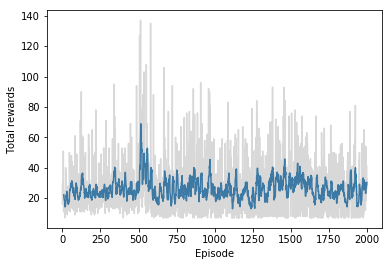

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

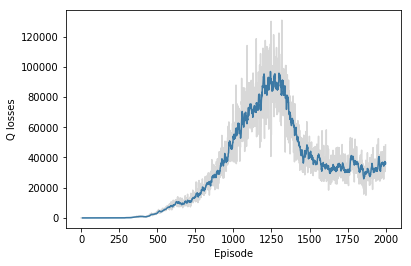

In [31]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'G losses')

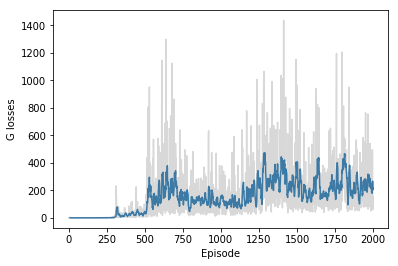

In [32]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

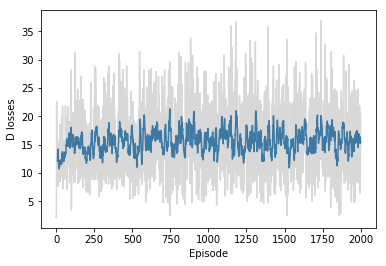

In [33]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from the model
            feed_dict = {model.prev_actions: np.array([prev_action]), 
                         model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, _ = env.step(prev_action)
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [36]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.